# Clustering Acoustic Emission Signals for Analyzing Damage Accumulation in Materials
## 1. Data preprocessing
First, import the necessary libraries.

In [77]:
# Numerical operations and data analysis
import numpy as np
import pandas as pd
# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import os  # Interacting with the operating system
import operator  # Performing operations on iterable data
from scipy import stats  # Statistical functions
from sklearn.decomposition import PCA  # Principal component analysis
from sklearn.cluster import KMeans  # K-means clustering
from sklearn.cluster import DBSCAN  # DBSCAN clustering
from sklearn.neighbors import NearestNeighbors  # Nearest neighbors calculation

### 1.1. Data cleaning
Next, combine the 'txt' files from the repository.

In [78]:
def prep_df(reposit):
    """ 
    The function joins 'txt' files from a repository.
    Parameters: reposit (str): Path to the repository containing 'txt' files.
    Returns: A tuple containing three DataFrames: the joined DataFrame, the energy DataFrame, and the load DataFrame.
    """    
    dfs = []
    for file_name in os.listdir(reposit):
        # Create a DataFrame from a 'txt' file
        df = pd.read_csv(reposit + '/' + file_name, sep='\t').iloc[1:].astype(float).set_index('Time [s]')
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Join all DataFrames inside the 'dfs' by the 'Time [s]' column except for the 'Energy' column
    df_fin = dfs[0].join(operator.itemgetter(*[1, 2, 3, 5])(dfs), 
                         how='inner').reset_index().drop_duplicates(subset='Time [s]')
    
    # Rename columns for consistency
    df_fin.rename(columns={'Time [s]':'Time_s', 'Amp [dB]':'Amp_dB', 'Riset [µs]': 'Riset_µs', 'Dur [µs]':'Dur_µs', 
                           'F(C.o.Gravity) [kHz]':'Freq_med_kHz', 'F(max. Amp.) [kHz]':'Freq_max_kHz'}, inplace=True)
    
    # Extract and rename columns for the 'Energy' DataFrame
    df_energy = dfs[-1].reset_index().copy()
    df_energy.rename(columns={'Time [s]':'Time_s', 'Energy [eu]':'Energy_eu'}, inplace=True)
    
    # Extract columns for the 'Load' DataFrame
    df_load = dfs[4].reset_index().copy()
    
    return (df_fin, df_energy, df_load)

Then, create a dictionary containing the combined files for each repository.

In [79]:
# Dictionary with all the data
dfs_dic = {}
for fold_name in next(os.walk('.'))[1][1:]:
    dfs_dic[fold_name] = prep_df(fold_name)

### 1.2 Dealing with Missing Values
Identify missing values.

In [81]:
# Missing values
for i in dfs_dic:
    print('Name of a DataFrame: {}\n{}\n'.format(i, dfs_dic[i][0].isnull().sum()))

Name of a DataFrame: 3х_изгиб_0Дж_1
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_0Дж_2
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_0Дж_3
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_1Дж_27
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_1Дж_28
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_3Дж_25
Time_s          0
Amp_dB          0
Riset_µs        0
Dur_µs          0
Freq_med_kHz    0
Freq_max_kHz    0
dtype: int64

Name of a DataFrame: 3х_изгиб_3Дж_26
Time_s      

There are no missing values.

### 1.3 Data Transformation
First, determine the skewness of the data.

In [82]:
# Skewness of data
for i in dfs_dic:
    print('Name of a DataFrame: {}\n{}\n'.format(i, dfs_dic[i][0].skew()))

Name of a DataFrame: 3х_изгиб_0Дж_1
Time_s          -0.090974
Amp_dB           1.115035
Riset_µs        17.251199
Dur_µs          30.119517
Freq_med_kHz    -0.791667
Freq_max_kHz     0.757534
dtype: float64

Name of a DataFrame: 3х_изгиб_0Дж_2
Time_s          -0.408553
Amp_dB           1.027843
Riset_µs        15.794009
Dur_µs          29.182144
Freq_med_kHz    -0.605397
Freq_max_kHz     0.188771
dtype: float64

Name of a DataFrame: 3х_изгиб_0Дж_3
Time_s          -0.212909
Amp_dB           1.860529
Riset_µs        43.205446
Dur_µs          31.282930
Freq_med_kHz    -0.888537
Freq_max_kHz     0.546012
dtype: float64

Name of a DataFrame: 3х_изгиб_1Дж_27
Time_s           0.099495
Amp_dB           1.265394
Riset_µs        38.793095
Dur_µs          38.441270
Freq_med_kHz    -0.930810
Freq_max_kHz     1.558644
dtype: float64

Name of a DataFrame: 3х_изгиб_1Дж_28
Time_s           0.715168
Amp_dB           1.308202
Riset_µs        20.595337
Dur_µs          29.492444
Freq_med_kHz    -1.196666


#### 1.3.1 Data Normalization
The 'Dur_µs' and 'Riset_µs' columns are highly skewed, so let's normalize them.

In [83]:
# Normalization of the 'Dur_µs' and 'Energy_eu' columns
dfs_dic_tr = dfs_dic.copy()
for i in dfs_dic:
    dfs_dic_tr[i][0]['Dur_µs'] = stats.boxcox(dfs_dic[i][0]['Dur_µs'])[0]
    dfs_dic_tr[i][0]['Riset_µs'] = stats.boxcox(dfs_dic[i][0]['Riset_µs'])[0]

In [84]:
# Skewness of data
for i in dfs_dic_tr:
    print('Name of a DataFrame: {}\n{}\n'.format(i, dfs_dic[i][0].skew()))

Name of a DataFrame: 3х_изгиб_0Дж_1
Time_s         -0.090974
Amp_dB          1.115035
Riset_µs       -0.011668
Dur_µs         -0.026510
Freq_med_kHz   -0.791667
Freq_max_kHz    0.757534
dtype: float64

Name of a DataFrame: 3х_изгиб_0Дж_2
Time_s         -0.408553
Amp_dB          1.027843
Riset_µs        0.015237
Dur_µs         -0.024901
Freq_med_kHz   -0.605397
Freq_max_kHz    0.188771
dtype: float64

Name of a DataFrame: 3х_изгиб_0Дж_3
Time_s         -0.212909
Amp_dB          1.860529
Riset_µs       -0.020440
Dur_µs         -0.027359
Freq_med_kHz   -0.888537
Freq_max_kHz    0.546012
dtype: float64

Name of a DataFrame: 3х_изгиб_1Дж_27
Time_s          0.099495
Amp_dB          1.265394
Riset_µs       -0.004817
Dur_µs         -0.029453
Freq_med_kHz   -0.930810
Freq_max_kHz    1.558644
dtype: float64

Name of a DataFrame: 3х_изгиб_1Дж_28
Time_s          0.715168
Amp_dB          1.308202
Riset_µs        0.003129
Dur_µs         -0.029202
Freq_med_kHz   -1.196666
Freq_max_kHz    0.800804
dtyp

The normalization has reduced the skewness of the 'Dur_µs' and 'Riset_µs' columns.

#### 1.3.2 Data Scaling
The next step is to scale the data.

In [85]:
# Scaling
for i in dfs_dic_tr:
    dfs_dic_tr[i] = (dfs_dic_tr[i][0] - dfs_dic_tr[i][0].min()) / (dfs_dic_tr[i][0].max() - dfs_dic_tr[i][0].min())

## 2. Cluster analysis
As an example, let's apply cluster analysis specifically to a subset containing data from a single experiment. The dataset contains five parameters: signal amplitude, rise time, duration, maximum frequency, and median frequency.

In [86]:
dfs_bend = dfs_dic_tr['3х_изгиб_0Дж_3'].iloc[:,1:].copy()
dfs_bend.head()

,Amp_dB,Riset_µs,Dur_µs,Freq_med_kHz,Freq_max_kHz
0,0.132712,0.312325,0.274761,0.434641,0.036145
1,0.164310,0.316628,0.275669,0.408497,0.036145
2,0.012639,0.000000,0.131152,0.571895,0.036145
3,0.132712,0.339860,0.217285,0.797386,0.316265
4,0.227506,0.370481,0.304264,0.333333,0.039157


### 2.1 Principal Component Analysis
We'll start by applying Principal Component Analysis (PCA) to reduce the dimensionality of the data.

Principal Component Analysis (PCA) is a linear dimensionality reduction technique widely utilized in exploratory data analysis, visualization, and data preprocessing. It transforms the data onto a new coordinate system, where the principal components capture the greatest variance in the data. This enables a more efficient representation of the data by highlighting the most significant patterns.


In [87]:
# Create principal components as an array
pca = PCA()
df_pca = pca.fit_transform(dfs_bend)

# Convert the array to DataFrame and name its columns
principal_component_names = [f"Principal_component_{i+1}" for i in range(df_pca.shape[1])]
df_pca = pd.DataFrame(df_pca, columns=principal_component_names)

# Display the first few rows of the PCA DataFrame
df_pca.head()

,Principal_component_1,Principal_component_2,Principal_component_3,Principal_component_4,Principal_component_5
0,-0.349088,0.128550,0.134977,-0.055044,0.000890
1,-0.353098,0.150569,0.161224,-0.038340,-0.014354
2,-0.358750,-0.246204,0.090542,0.023753,0.052940
3,0.001522,0.025482,-0.140955,-0.003001,-0.040541
4,-0.357869,0.245280,0.221554,-0.030154,-0.040251


The next step is to show how each original feature contributes to each principal component. This is useful for interpreting the principal components in terms of the original features. Each value in the DataFrame represents the weight or loading of an original feature on a particular principal component.

In [88]:
# Create a DataFrame for principal component loadings (weights)
weights = pd.DataFrame(pca.components_.T, columns=principal_component_names, index=dfs_bend.columns)
weights

,Principal_component_1,Principal_component_2,Principal_component_3,Principal_component_4,Principal_component_5
Amp_dB,0.040052,0.415911,0.109147,0.798159,-0.420051
Riset_µs,0.089932,0.704466,-0.292519,-0.524755,-0.367022
Dur_µs,0.046786,0.533693,-0.026002,0.159291,0.828814
Freq_med_kHz,0.218237,-0.205089,-0.921093,0.244914,0.043775
Freq_max_kHz,0.969789,-0.062099,0.231152,-0.047100,0.001548


In the table above, we observe the loading values. A high absolute value of a loading indicates a strong contribution of that variable to the principal component, while positive and negative signs indicate the direction of the relationship. By examining the loadings, we can understand how much each original variable contributes to each principal component. For instance, 'Freq_max_kHz' has a loading of approximately 0.97, indicating it contributes positively and strongly to the first principal component (PC1).

Principal components are linear combinations (weighted sums) of the original features. For example, PC1 can be expressed as:
PC1 = 0.040052 * Amp_dB + 0.089932 * Riset_µs + 0.046786 * Dur_µs + 0.218237 * Freq_med_kHz + 0.969789 * Freq_max_kHz

[Text(0.5, 0, 'Principal Component'),
 Text(0, 0.5, 'Cumulative Variance (%)'),
 (0.0, 1.0)]

<Figure size 432x288 with 0 Axes>

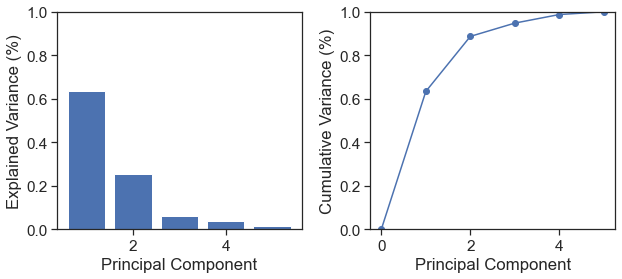

In [89]:
# Create a new figure for plotting
f = plt.figure()

# Set the font scale and style for the plots
sns.set(font_scale=1.4)
sns.set_style("ticks")

# Create subplots: 1 row and 2 columns, with specified figure size
f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.28)  # Adjust space between subplots

n = pca.n_components_ # Define the number of principal components
gr = np.arange(1, n + 1)  # Create an array of indices for the principal components

# Plot the explained variance ratio
exp_var = pca.explained_variance_ratio_  # Get the variance explained by each principal component
ax[0].bar(gr, exp_var)  # Create a bar plot for the explained variance ratios
ax[0].set(xlabel="Principal Component", ylabel="Explained Variance (%)", ylim=(0.0, 1.0))
# The x-axis represents the principal components, and the y-axis shows the percentage of variance explained

# Plot the cumulative variance
cum_var = np.cumsum(exp_var)  # Calculate the cumulative variance explained
ax[1].plot(np.r_[0, gr], np.r_[0, cum_var], "o-")  # Plot the cumulative variance
ax[1].set(xlabel="Principal Component", ylabel="Cumulative Variance (%)", ylim=(0.0, 1.0))
# The x-axis represents the principal components, and the y-axis shows the cumulative percentage of variance explained

# Save the figure as a PNG file with tight bounding box and high resolution
# f.savefig("Fig_1.png", bbox_inches='tight', dpi=600)

The figure above illustrates the variance explained by each principal component in the dataset. Each value in the explained variance ratio represents the proportion of the dataset's total variance captured by that particular principal component. Higher values indicate that the principal component explains more of the variance in the data. For instance, PC1 captures more variation than PC2. In the provided example, the first component explains approximately 63% of the total variance, while the second explains about 25%. This metric is crucial in PCA as it quantifies how much information each principal component contributes to the dataset's overall variance.

Summing these explained variance ratios provides the cumulative variance explained by the principal components considered. In the example given, the cumulative variance explained by the first two components is 0.634 + 0.253 = 0.887, meaning they collectively explain about 89% of the total variance. Including the first three components would explain approximately 95% of the total variance.

Understanding the explained variance ratio assists in determining the number of principal components to retain for dimensionality reduction. Keeping components that collectively explain a high cumulative variance (e.g., 90% or more) allows for reducing the dataset’s dimensionality while retaining most of its essential information.

### 4.2 Clustering
The distribution of data through the 1st and 2nd principal components is depicted below.

Text(0, 0.5, 'Principal component 2')

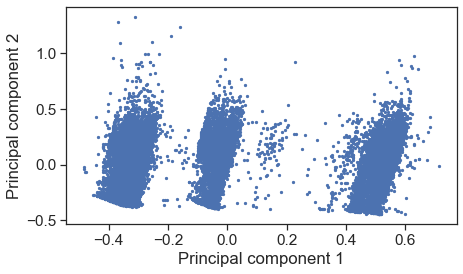

In [90]:
# Create a new figure and a single subplot with specified figure size
f, ax = plt.subplots(figsize=(7, 4))

# Set font scale and plot style
sns.set(font_scale=1.5)
sns.set_style("ticks")

# Scatter plot of the first two principal components
plt.scatter(
    x=df_pca['Principal_component_1'],  # x-axis values: first principal component
    y=df_pca['Principal_component_2'],  # y-axis values: second principal component
    s=5,  # Size of each point in the scatter plot
)

# Set axis labels
plt.xlabel("Principal component 1")  # Label for the x-axis
plt.ylabel("Principal component 2")  # Label for the y-axis

We observe three distinct clusters in the figure below. Next, let's apply the widely-used k-means algorithm for further cluster analysis.
#### 4.2.1 K-means algorithm

In [91]:
kmeans = KMeans(n_clusters=3)  # Initialize KMeans clustering with the desired number of clusters (k)
kmeans.fit(df_pca.iloc[:,:3]) # Fit the KMeans model to the data using the first three principal components

# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

df_pca['Kmean_cl'] = labels # Add the cluster labels as a new column in the DataFrame
df_pca.head() # Display the first few rows of the DataFrame

,Principal_component_1,Principal_component_2,Principal_component_3,Principal_component_4,Principal_component_5,Kmean_cl
0,-0.349088,0.128550,0.134977,-0.055044,0.000890,1
1,-0.353098,0.150569,0.161224,-0.038340,-0.014354,1
2,-0.358750,-0.246204,0.090542,0.023753,0.052940,0
3,0.001522,0.025482,-0.140955,-0.003001,-0.040541,1
4,-0.357869,0.245280,0.221554,-0.030154,-0.040251,1


Text(0, 0.5, 'Principal component 2')

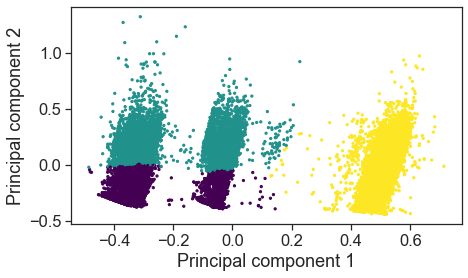

In [92]:
# Create a new figure and a single subplot with specified figure size
f, ax = plt.subplots(figsize=(7, 4))

# Set font scale and plot style
sns.set(font_scale=1.5)
sns.set_style("ticks")

# Scatter plot of the first two principal components
plt.scatter(x=df_pca['Principal_component_1'], y=df_pca['Principal_component_2'], c=df_pca['Kmean_cl'], s=5, cmap='viridis')

# Set axis labels
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

In the figure above, the dark violet cluster appears to be well-formed, but the other two clusters are not correctly identified. This issue arises due to the elongated nature of the initial data distributions. For such elongated clusters, it is more effective to use advanced algorithms like DBSCAN.
#### 4.2.2 DBSCAN algorithm
Before applying the DBSCAN algorithm, let's determine an appropriate epsilon value by analyzing the distances to the nearest neighbors in the dataset.

Text(0.5, 0, 'AE events')

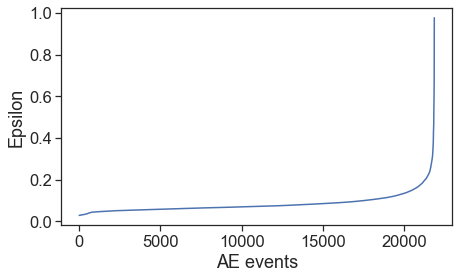

In [93]:
f, ax = plt.subplots(figsize=(7, 4))  # Create a figure and an axis with a specific size

K = 400  # Set the minimum number of Acoustic Emission (AE) events for each cluster
distances = {}  # Initialize a dictionary to store distances
indices = {}  # Initialize a dictionary to store indices
Eps = {}  # Initialize a dictionary to store epsilon values

# Calculate the distances from each AE event to its K nearest neighbors
nbrs = NearestNeighbors(n_neighbors=K).fit(df_pca.iloc[:, :3])  # Fit the model on the first three principal components
distances[0], indices[0] = nbrs.kneighbors(df_pca.iloc[:, :3])  # Compute the K-nearest neighbors 

# Determine the maximum epsilon value for 90% of the AE events
Eps = np.sort(distances[0], axis=0)[(len(distances[0]) * 0.9).__round__(), -1]

g = plt.plot(np.sort(distances[0], axis=0)[:, -1], label=0)  # Plot the sorted distances for the furthest neighbors

plt.ylabel('Epsilon')  # Set the y-axis label
plt.xlabel('AE events')  # Set the x-axis label

After determining the appropriate epsilon value, we can use it to apply the DBSCAN algorithm.

In [94]:
# Initialize DBSCAN clustering with the specified epsilon value and minimum number of samples per cluster
DBSc = DBSCAN(eps=Eps, min_samples=K)
# Apply the DBSCAN algorithm to the data using the first three principal components
DBS_pred = DBSc.fit_predict(df_pca.iloc[:,:3])

df_pca['DBSc_cl'] = DBS_pred # Add the cluster labels assigned by DBSCAN as a new column in the DataFrame
df_pca.head() # Display the first few rows of the DataFrame

,Principal_component_1,Principal_component_2,Principal_component_3,Principal_component_4,Principal_component_5,Kmean_cl,DBSc_cl
0,-0.349088,0.128550,0.134977,-0.055044,0.000890,1,0
1,-0.353098,0.150569,0.161224,-0.038340,-0.014354,1,0
2,-0.358750,-0.246204,0.090542,0.023753,0.052940,0,0
3,0.001522,0.025482,-0.140955,-0.003001,-0.040541,1,1
4,-0.357869,0.245280,0.221554,-0.030154,-0.040251,1,0


Text(0, 0.5, 'Principal component 2')

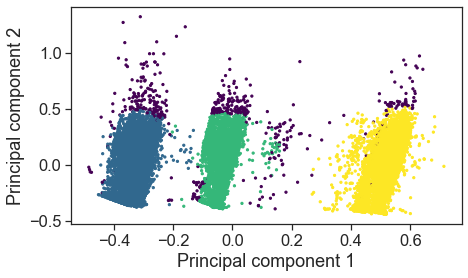

In [95]:
# Create a new figure and a single subplot with specified figure size
f, ax = plt.subplots(figsize=(7, 4))

# Set font scale and plot style
sns.set(font_scale=1.5)
sns.set_style("ticks")

# Scatter plot of the first two principal components
plt.scatter(x=df_pca['Principal_component_1'], y=df_pca['Principal_component_2'], c=df_pca['DBSc_cl'], s=5, cmap='viridis')

# Set axis labels
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0.5, 0, 'Principal component 3')

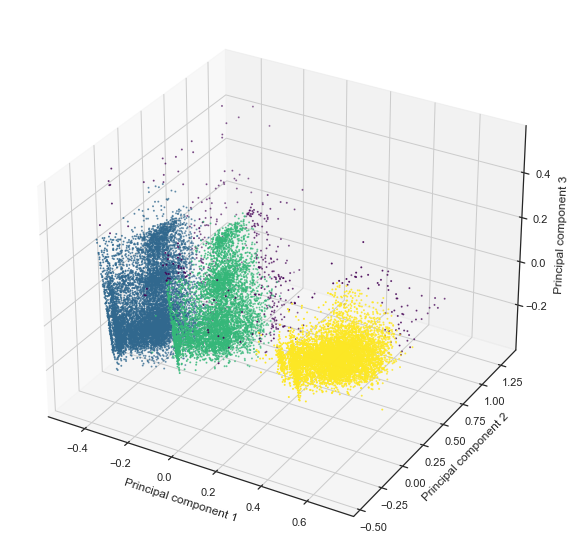

In [103]:
fig = plt.figure(figsize=(10, 10)) # Create a new figure with a specified size
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot to the figure

# Set the style for seaborn plots
sns.set(style="darkgrid")
sns.set_style("ticks")

# Create a 3D scatter plot
ax.scatter(df_pca['Principal_component_1'], 
           df_pca['Principal_component_2'], 
           df_pca['Principal_component_3'], 
           c=df_pca['DBSc_cl'], # - 'c' specifies the colors of the points based on DBSCAN cluster labels
           s=1, # - 's' sets the size of the scatter plot markers
           cmap='viridis' # - 'cmap' determines the colormap used for coloring the points
)

# Label the axes of the 3D plot
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
ax.set_zlabel("Principal component 3")

The DBSCAN algorithm has categorized the data into three clusters, represented by blue, green, and yellow colors, and identified outliers, shown in dark violet. Thus, DBSCAN is more effective for this type of acoustic emission data, making it a suitable choice for analyzing the entire dataset.